In [1]:
import os
import kagglehub

path = kagglehub.dataset_download("fakhrealam9537/leaf-disease-segmentation-dataset")
print("Path to dataset files:", path)

aug_data_dir = os.path.join(path, "aug_data", "aug_data")  
if not os.path.exists(aug_data_dir):
    aug_data_dir = os.path.join(path, "aug_data")  

print("Augmented Data Directory:", aug_data_dir)
if os.path.exists(aug_data_dir):
    print(os.listdir(aug_data_dir))

image_dir = os.path.join(aug_data_dir, "images")
mask_dir = os.path.join(aug_data_dir, "masks")

print("Images Directory Exists:", os.path.exists(image_dir))
print("Masks Directory Exists:", os.path.exists(mask_dir))

if os.path.exists(image_dir):
    image_source_dir = image_dir
else:
    image_source_dir = None
    print("Error: Images directory not found!")

if os.path.exists(mask_dir):
    mask_source_dir = mask_dir
else:
    mask_source_dir = None
    print("Error: Masks directory not found!")

print("Image Source Directory:", image_source_dir)
print("Mask Source Directory:", mask_source_dir)


Path to dataset files: /kaggle/input/
Augmented Data Directory: /kaggle/input/aug_data/aug_data
['images', 'masks']
Images Directory Exists: True
Masks Directory Exists: True
Image Source Directory: /kaggle/input/aug_data/aug_data/images
Mask Source Directory: /kaggle/input/aug_data/aug_data/masks


In [2]:
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
from matplotlib.colors import ListedColormap

# image_dir = "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/images"
# mask_dir = "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/masks"

# image_dir = "D:/THESIS/thesis-dataset/aug_data/aug_data/images"
# mask_dir = "D:/THESIS/thesis-dataset/aug_data/aug_data/masks"

image_dir = "/kaggle/input/aug_data/aug_data/images"
mask_dir = "/kaggle/input/aug_data/aug_data/masks"

IMG_WIDTH, IMG_HEIGHT = 256, 256
BATCH_SIZE = 16
SEED = 42
torch.manual_seed(SEED)

Unique classes in mask: [ 0 38]


<ipython-input-3-13ad924711eb>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ListedColormap(plt.cm.get_cmap("tab20", num_classes).colors)


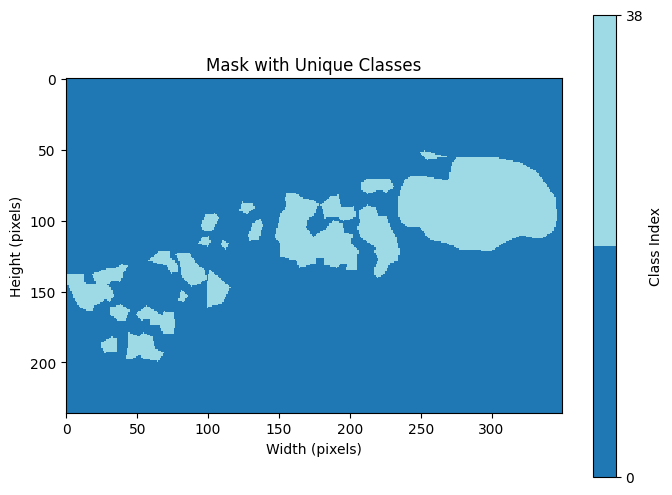

2

In [3]:
def visualize_label_mapping(mask_path):
    mask = Image.open(mask_path).convert("L")
    mask_array = np.array(mask)

    unique_classes = np.unique(mask_array)
    num_classes = len(unique_classes)
    print(f"Unique classes in mask: {unique_classes}")

    cmap = (
        ListedColormap(plt.cm.get_cmap("tab20", num_classes).colors)
        if num_classes <= 20
        else plt.cm.get_cmap("viridis", num_classes)
    )

    plt.figure(figsize=(8, 6))
    plt.imshow(mask_array, cmap=cmap, interpolation="nearest")
    plt.colorbar(ticks=unique_classes, label="Class Index")
    plt.title("Mask with Unique Classes")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.grid(False)
    plt.show()

    return num_classes


# custom_mask_path = '/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/masks/00002_0.png'
# custom_mask_path = "D:/THESIS/thesis-dataset/aug_data/aug_data/masks/00002_0.png"
custom_mask_path = "/kaggle/input/aug_data/aug_data/masks/00002_0.png"
visualize_label_mapping(custom_mask_path)

In [4]:
def find_num_classes(mask_dir):
    unique_classes = set()
    for mask_filename in os.listdir(mask_dir):
        if mask_filename.endswith((".png")):
            mask_path = os.path.join(mask_dir, mask_filename)
            mask = Image.open(mask_path).convert("L")
            mask_array = np.array(mask)
            unique_classes.update(np.unique(mask_array))

    num_classes = len(unique_classes)
    print(f"Unique classes across all masks: {sorted(unique_classes)}")
    print(f"Number of classes: {num_classes}")
    return num_classes

# mask_directory = (
#     "D:/THESIS/thesis-dataset/aug_data/aug_data/masks"
# )
mask_directory = (
    "/kaggle/input/aug_data/aug_data/masks"
)

# mask_directory = (
#     "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/masks"
# )
num_classes = find_num_classes(mask_directory)

Unique classes across all masks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
Number of classes: 39


In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )

        self.transform_mask = transforms.Compose(
            [
                transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
            ]
        )

        unique_classes = set()
        for mask_path in self.mask_files:
            mask = np.array(
                Image.open(os.path.join(self.mask_dir, mask_path)).convert("L")
            )
            unique_classes.update(np.unique(mask))
        self.class_map = {val: idx for idx, val in enumerate(sorted(unique_classes))}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        image = self.transform(image)
        mask = torch.from_numpy(
            np.array(mask.resize((IMG_WIDTH, IMG_HEIGHT), Image.Resampling.NEAREST))
        ).long()

        # Ensure mask is mapped using class_map
        mask = np.vectorize(self.class_map.get)(mask)
        mask = torch.from_numpy(mask).long()

        return image, mask


dataset = SegmentationDataset(image_dir, mask_dir)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Total Dataset: {len(dataset)}")
print(f"Train Size: {len(train_dataset)}")
print(f"Validation Size: {len(val_dataset)}")
print(f"Test Size: {len(test_dataset)}")

Total Dataset: 2940
Train Size: 2058
Validation Size: 441
Test Size: 441


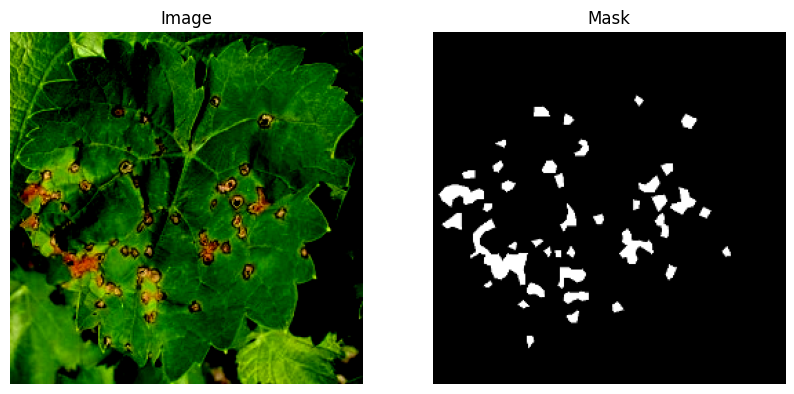

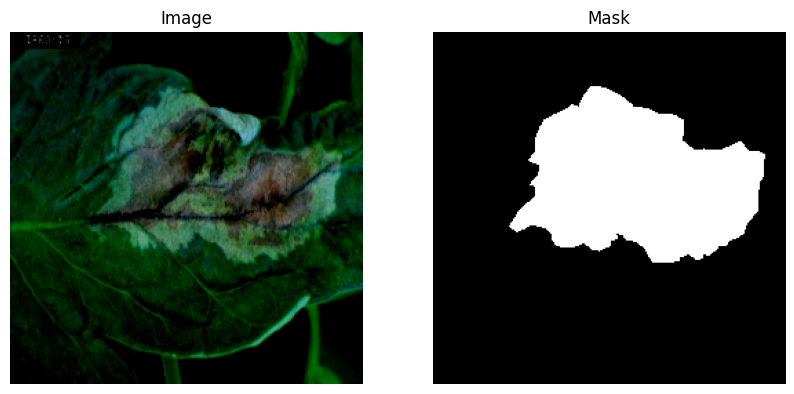

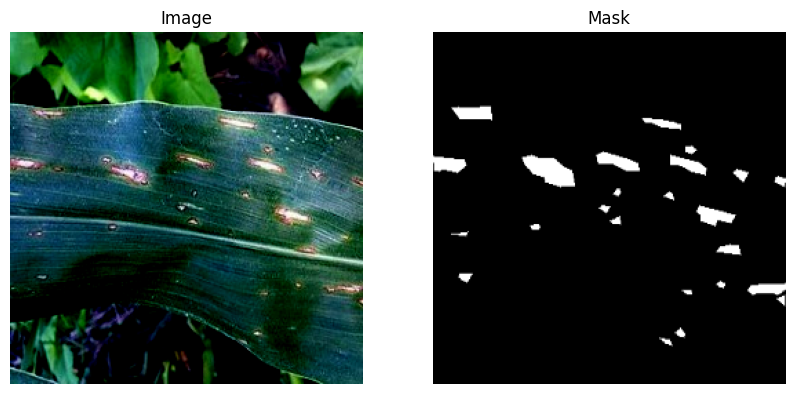

In [6]:
def show_data_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, mask = dataset[i]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Image")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")
        plt.show()


show_data_samples(train_dataset, num_samples=3)

In [7]:
def count_rgb_images(split_dataset):
    rgb_count = 0
    non_rgb_count = 0

    for idx in range(len(split_dataset)):
        image, _ = split_dataset[idx]
        if image.shape[0] == 3:
            rgb_count += 1
        else:
            non_rgb_count += 1

    return rgb_count, non_rgb_count


train_rgb, train_non_rgb = count_rgb_images(train_dataset)
val_rgb, val_non_rgb = count_rgb_images(val_dataset)
test_rgb, test_non_rgb = count_rgb_images(test_dataset)

print(f"Train Dataset: {train_rgb} RGB, {train_non_rgb} Non-RGB")
print(f"Validation Dataset: {val_rgb} RGB, {val_non_rgb} Non-RGB")
print(f"Test Dataset: {test_rgb} RGB, {test_non_rgb} Non-RGB")

Train Dataset: 2058 RGB, 0 Non-RGB
Validation Dataset: 441 RGB, 0 Non-RGB
Test Dataset: 441 RGB, 0 Non-RGB


In [8]:
def count_mask_types(mask_dir):
    binary_count = 0
    multiclass_count = 0

    mask_files = os.listdir(mask_dir)
    if not mask_files:
        print(f"No files found in the directory: {mask_dir}")
        return

    for mask_file in mask_files:
        mask_path = os.path.join(mask_dir, mask_file)

        try:
            mask = np.array(Image.open(mask_path))
            unique_values = np.unique(mask)

            if len(unique_values) == 2:
                binary_count += 1
            else:
                multiclass_count += 1
        except Exception as e:
            print(f"Error processing {mask_file}: {e}")

    print(f"Number of Binary Masks: {binary_count}")
    print(f"Number of Multi-class Masks: {multiclass_count}")
    print(f"Total Masks: {binary_count + multiclass_count}")
    print(f"Percentage of Binary Masks: {(binary_count / len(mask_files)) * 100:.2f}%")
    print(
        f"Percentage of Multi-class Masks: {(multiclass_count / len(mask_files)) * 100:.2f}%"
    )


count_mask_types(mask_dir)

Number of Binary Masks: 1560
Number of Multi-class Masks: 1380
Total Masks: 2940
Percentage of Binary Masks: 53.06%
Percentage of Multi-class Masks: 46.94%


In [9]:
# analyze_class_distribution(train_dataset) only processes masks included in the train_dataset [2058] split.

def analyze_class_distribution(dataset):
    class_counts = Counter()

    for _, mask in dataset:
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        class_counts.update(dict(zip(unique, counts)))

    print("Class distribution in dataset:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} pixels")


analyze_class_distribution(train_dataset)

Class distribution in dataset:
Class 0: 112660552 pixels
Class 1: 30934 pixels
Class 2: 35779 pixels
Class 3: 26134 pixels
Class 4: 28654 pixels
Class 5: 31963 pixels
Class 6: 22372 pixels
Class 7: 20821 pixels
Class 8: 29667 pixels
Class 9: 23683 pixels
Class 10: 22753 pixels
Class 11: 26288 pixels
Class 12: 19756 pixels
Class 13: 22044 pixels
Class 14: 30222 pixels
Class 15: 19905 pixels
Class 16: 18310 pixels
Class 17: 26664 pixels
Class 18: 19412 pixels
Class 19: 28207 pixels
Class 20: 27403 pixels
Class 21: 19213 pixels
Class 22: 20684 pixels
Class 23: 29673 pixels
Class 24: 19451 pixels
Class 25: 20612 pixels
Class 26: 26015 pixels
Class 27: 21362 pixels
Class 28: 21351 pixels
Class 29: 29338 pixels
Class 30: 20395 pixels
Class 31: 29198 pixels
Class 32: 23824 pixels
Class 33: 28311 pixels
Class 34: 34464 pixels
Class 35: 24503 pixels
Class 36: 26583 pixels
Class 37: 43376 pixels
Class 38: 21263212 pixels


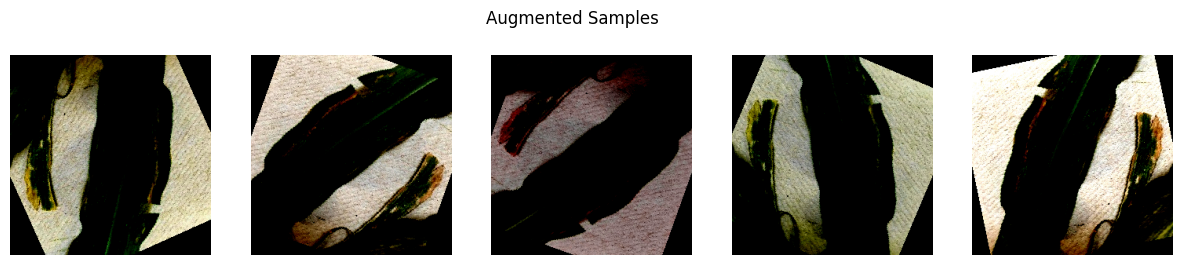

In [10]:
augmentation_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)


def visualize_augmentations(image_path, num_augmentations=5):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(15, 3))
    for i in range(num_augmentations):
        augmented_image = augmentation_transform(image)
        plt.subplot(1, num_augmentations, i + 1)
        plt.imshow(augmented_image.permute(1, 2, 0).numpy())
        plt.axis("off")
    plt.suptitle("Augmented Samples")
    plt.show()


visualize_augmentations(os.path.join(image_dir, os.listdir(image_dir)[0]))

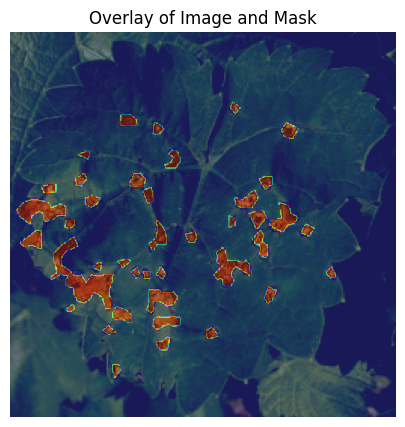

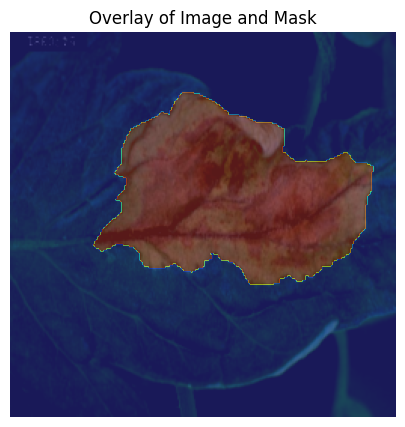

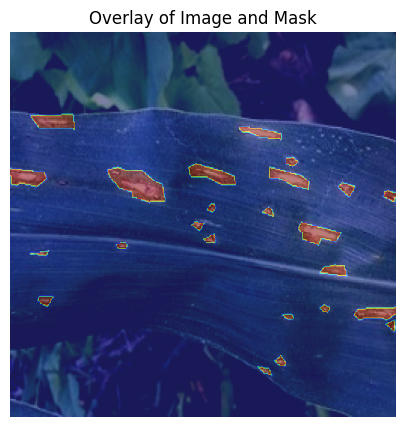

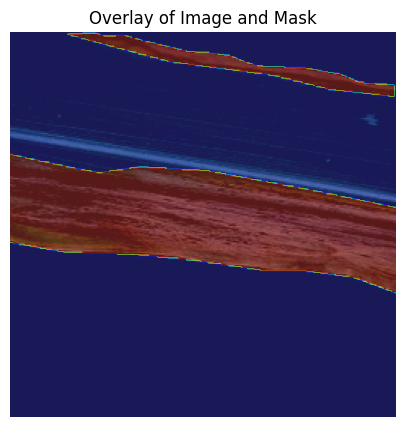

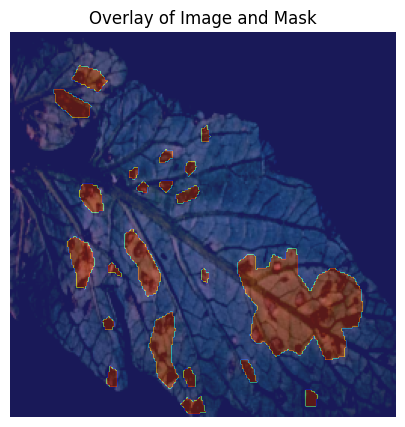

In [11]:
def overlay_masks(image, mask):
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(image_np, alpha=0.8)
    plt.imshow(mask_np, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title("Overlay of Image and Mask")
    plt.show()


for i in range(5):
    image, mask = train_dataset[i]
    overlay_masks(image, mask)

In [12]:
def dataset_summary(dataset):
    total_images = len(dataset)
    heights, widths = [], []
    class_counts = Counter()

    for image, mask in dataset:
        heights.append(image.shape[1])
        widths.append(image.shape[2])
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        class_counts.update(dict(zip(unique, counts)))

    print(f"Total Images: {total_images}")
    print(
        f"Image Dimensions: Min={min(heights)}x{min(widths)}, Max={max(heights)}x{max(widths)}"
    )


dataset_summary(train_dataset)

Total Images: 2058
Image Dimensions: Min=256x256, Max=256x256


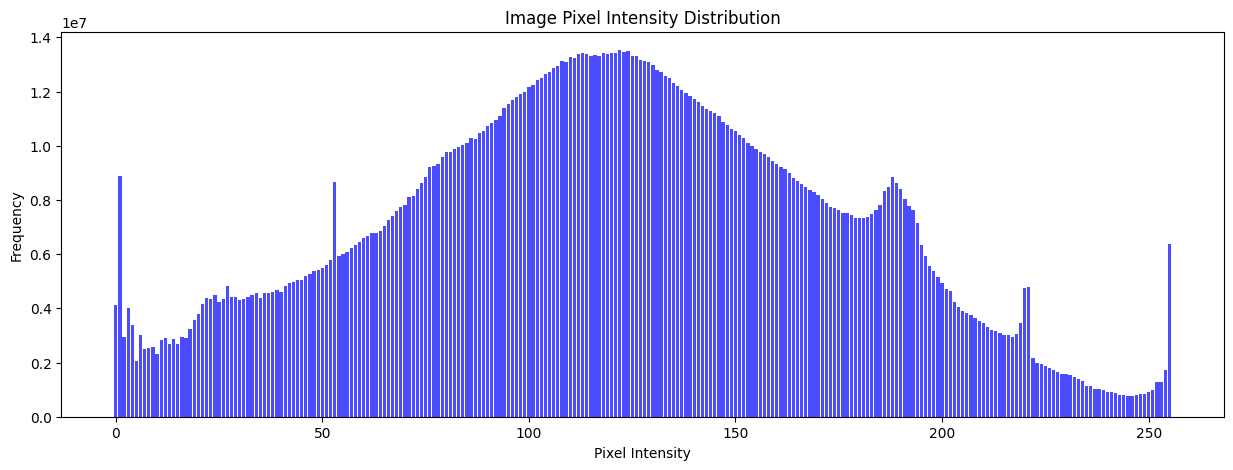

In [13]:
def pixel_intensity_analysis(image_dir):
    image_intensity_counts = np.zeros(256)

    for image_file in sorted(os.listdir(image_dir)):
        image_path = os.path.join(image_dir, image_file)
        image = np.array(Image.open(image_path).convert("L"))

        unique, counts = np.unique(image, return_counts=True)
        image_intensity_counts[unique] += counts

    plt.figure(figsize=(15, 5))
    plt.bar(range(256), image_intensity_counts, color="blue", alpha=0.7)
    plt.title("Image Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()


pixel_intensity_analysis(image_dir)

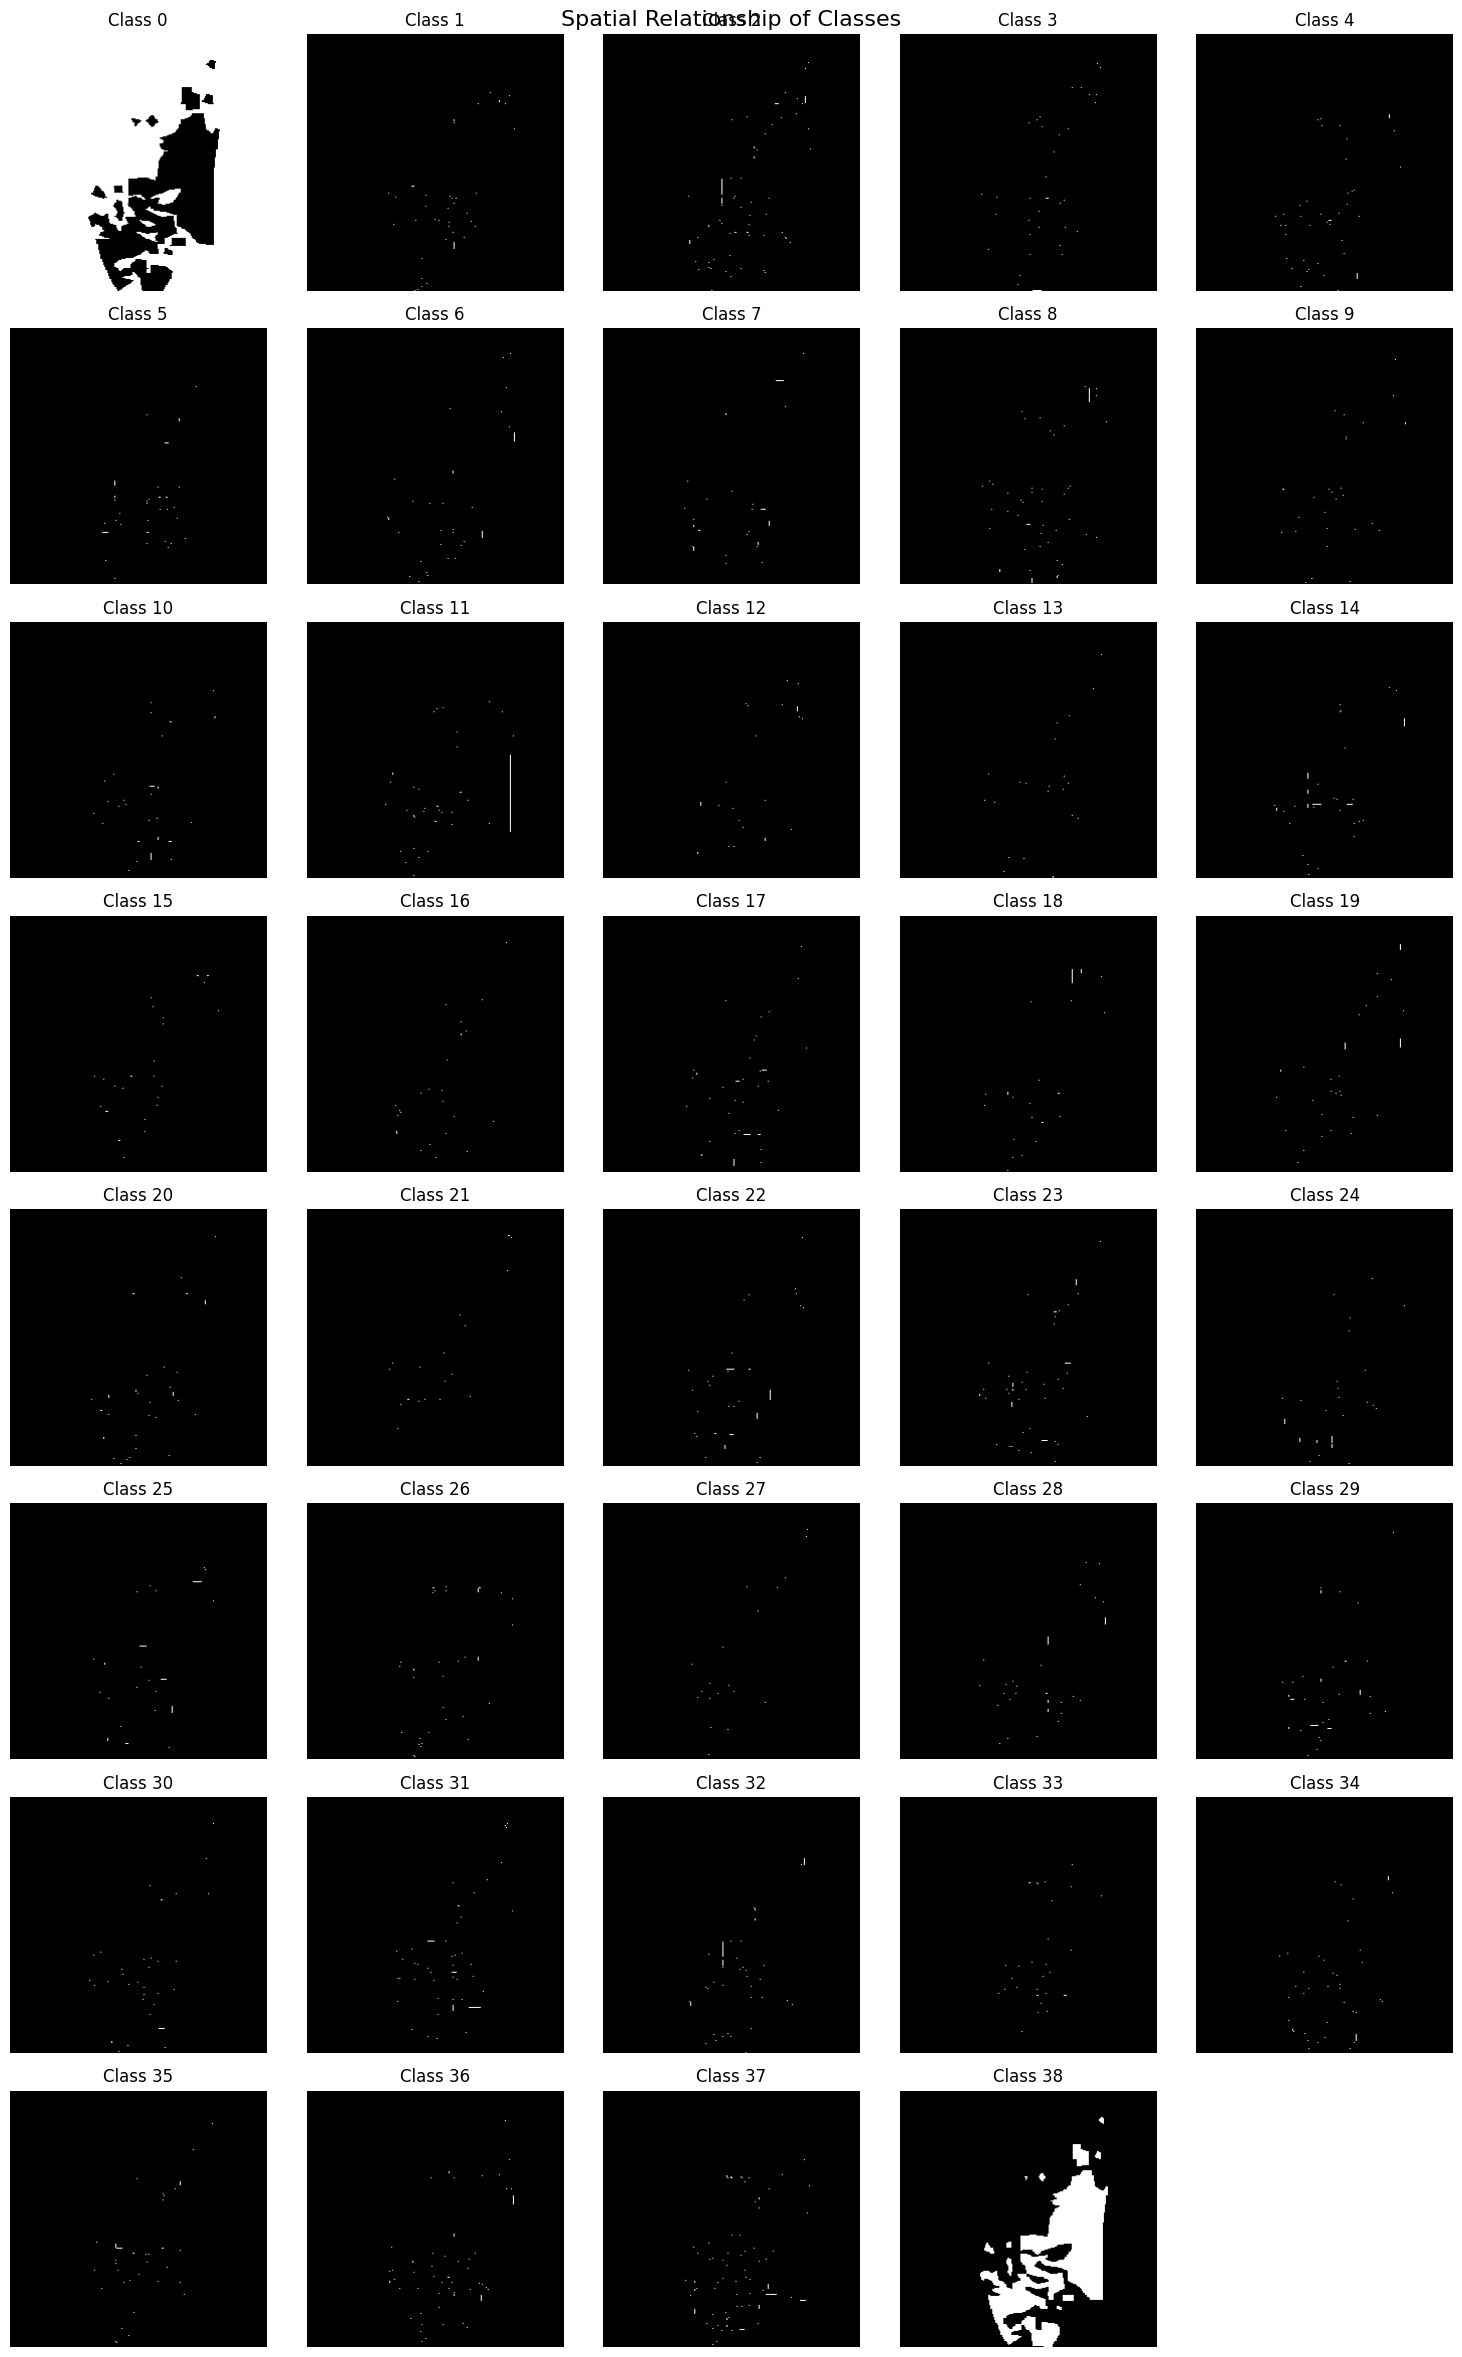

In [14]:
def visualize_class_relationships(mask_path):
    mask = np.array(Image.open(mask_path).convert("L"))
    unique_classes = np.unique(mask)

    num_classes = len(unique_classes)
    cols = 5
    rows = (num_classes + cols - 1) // cols

    plt.figure(figsize=(15, 3 * rows))

    for idx, cls in enumerate(unique_classes):
        binary_mask = (mask == cls).astype(np.uint8)
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(binary_mask, cmap="gray")
        plt.title(f"Class {cls}")
        plt.axis("off")

    plt.suptitle("Spatial Relationship of Classes", fontsize=16)
    plt.tight_layout()
    plt.show()


mask_example_path = os.path.join(mask_dir, os.listdir(mask_dir)[0])
visualize_class_relationships(mask_example_path)

Class Pixel Counts:
Class 0: 1538658705 pixels
Class 38: 270806410 pixels
Class 1: 44710 pixels
Class 2: 52005 pixels
Class 3: 37915 pixels
Class 4: 41095 pixels
Class 5: 45935 pixels
Class 6: 32470 pixels
Class 7: 30120 pixels
Class 8: 42660 pixels
Class 9: 34140 pixels
Class 10: 32135 pixels
Class 11: 38555 pixels
Class 12: 28490 pixels
Class 13: 31520 pixels
Class 14: 43465 pixels
Class 15: 28800 pixels
Class 16: 26825 pixels
Class 17: 38945 pixels
Class 18: 27995 pixels
Class 19: 38560 pixels
Class 20: 39465 pixels
Class 21: 27635 pixels
Class 22: 30130 pixels
Class 23: 43050 pixels
Class 24: 27640 pixels
Class 25: 29625 pixels
Class 26: 37140 pixels
Class 27: 31485 pixels
Class 28: 30225 pixels
Class 29: 42650 pixels
Class 30: 28985 pixels
Class 31: 41445 pixels
Class 32: 33855 pixels
Class 33: 41125 pixels
Class 34: 49135 pixels
Class 35: 35525 pixels
Class 36: 38420 pixels
Class 37: 61745 pixels


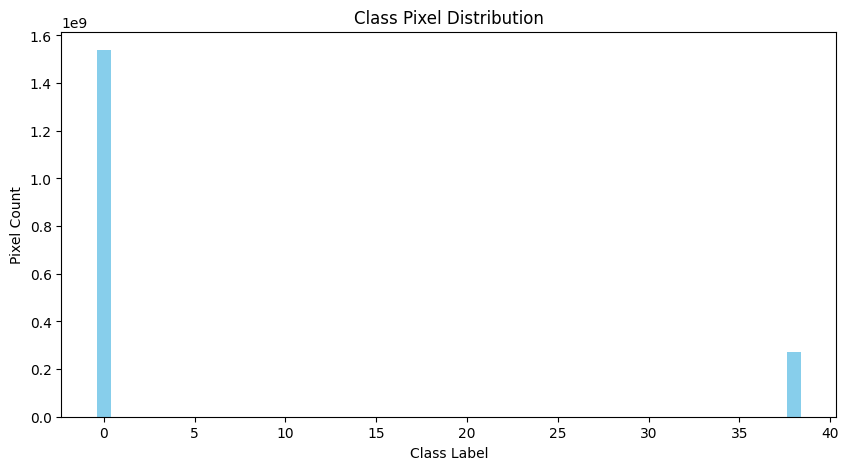

In [15]:
# check_class_imbalance(mask_dir) analyzes all masks in the mask_dir.

from collections import Counter


def check_class_imbalance(mask_dir):
    class_counts = Counter()
    for mask_file in sorted(os.listdir(mask_dir)):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = np.array(Image.open(mask_path).convert("L"))
        unique, counts = np.unique(mask, return_counts=True)
        class_counts.update(dict(zip(unique, counts)))

    print("Class Pixel Counts:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} pixels")

    classes, counts = zip(*sorted(class_counts.items()))
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color="skyblue")
    plt.xlabel("Class Label")
    plt.ylabel("Pixel Count")
    plt.title("Class Pixel Distribution")
    plt.show()


check_class_imbalance(mask_dir)

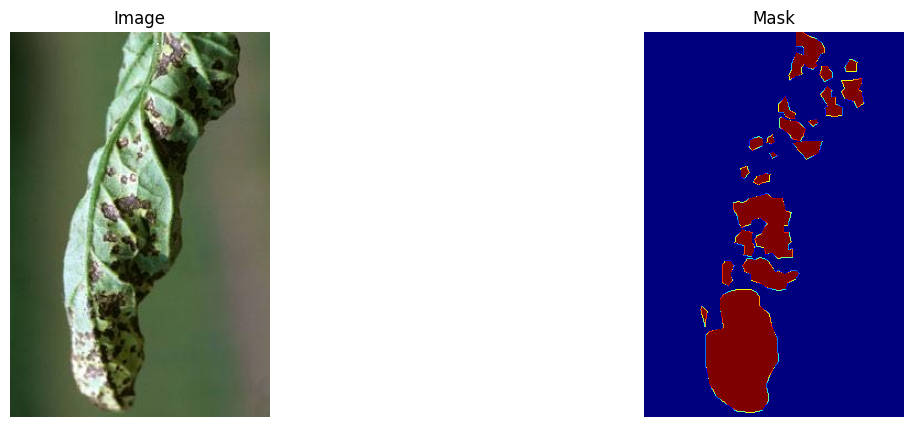

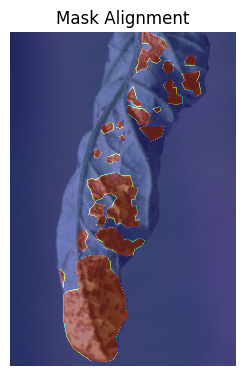

In [16]:
def check_mask_alignment(image_path, mask_path):
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="jet")
    plt.title("Mask")
    plt.axis("off")
    plt.show()

    plt.subplot(1, 2, 2)
    plt.imshow(image, alpha=0.8)
    plt.imshow(mask, cmap="jet", alpha=0.5)
    plt.title("Mask Alignment")
    plt.axis("off")
    plt.show()


# custom_image_path = "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/images/00002_1.jpg"
# custom_mask_path = "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/masks/00002_1.png"

#custom_image_path = "D:/THESIS/thesis-dataset/aug_data/aug_data/images/00002_1.jpg"
#custom_mask_path = "D:/THESIS/thesis-dataset/aug_data/aug_data/masks/00002_1.png"

custom_image_path = "/kaggle/input/aug_data/aug_data/images/00002_1.jpg"
custom_mask_path = "/kaggle/input/aug_data/aug_data/masks/00002_1.png"

check_mask_alignment(custom_image_path, custom_mask_path)

YOLOv11_seg

In [17]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import pandas as pd
from IPython.display import FileLink

# Directories for dataset (use appropriate Kaggle paths)
image_dir = "/kaggle/input/aug_data/aug_data/images"
mask_dir = "/kaggle/input/aug_data/aug_data/masks"

IMG_WIDTH, IMG_HEIGHT = 256, 256
BATCH_SIZE = 32
EPOCHS = 500
SEED = 42

torch.manual_seed(SEED)

# Custom Dataset class for segmentation task
class SegmentationDataset_1(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_image = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )
        self.transform_mask = transforms.Compose(
            [
                transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
            ]
        )

        unique_classes = set()
        for mask_path in self.mask_files:
            mask = np.array(
                Image.open(os.path.join(self.mask_dir, mask_path)).convert("L")
            )
            unique_classes.update(np.unique(mask))
        self.class_map = {val: idx for idx, val in enumerate(sorted(unique_classes))}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = self.transform_image(image)
        mask = np.array(self.transform_mask(mask), dtype=np.int64)

        mask = np.vectorize(self.class_map.get)(mask)
        mask = torch.from_numpy(mask).long()

        return image, mask


# Split dataset into train, validation, and test sets
dataset = SegmentationDataset_1(image_dir, mask_dir)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

all_masks = sorted(os.listdir(mask_dir))
unique_classes = set()
for mask_file in all_masks:
    mask = np.array(Image.open(os.path.join(mask_dir, mask_file)).convert("L"))
    unique_classes.update(np.unique(mask))
num_classes = len(unique_classes)
print(f"Number of classes: {num_classes}")


# YOLO-inspired Segmentation Model (YOLOv1)
class YOLOv11(nn.Module):
    def __init__(self, num_classes):
        super(YOLOv11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=1),
            nn.Upsample(
                size=(IMG_HEIGHT, IMG_WIDTH), mode="bilinear", align_corners=True
            ),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.decoder(x)
        return x


model = YOLOv11(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Calculate IoU
def calculate_iou(preds, masks, num_classes):
    preds = torch.argmax(preds, dim=1).view(-1).cpu().numpy()
    masks = masks.view(-1).cpu().numpy()
    iou = jaccard_score(masks, preds, average='macro', labels=range(num_classes))
    return iou


# Training for one epoch with metrics
def train_one_epoch_with_metrics(model, loader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    epoch_iou = 0
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
        masks = masks.view(-1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_iou += calculate_iou(outputs, masks, num_classes)
    return epoch_loss / len(loader), epoch_iou / len(loader)


# Validation for one epoch with metrics
def validate_one_epoch_with_metrics(model, loader, criterion):
    model.eval()
    val_loss = 0
    val_iou = 0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = outputs.permute(0, 2, 3, 1).reshape(-1, num_classes)
            masks = masks.view(-1)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_iou += calculate_iou(outputs, masks, num_classes)
    return val_loss / len(loader), val_iou / len(loader)


# Early stopping parameters
early_stop_patience = 10
early_stop_counter = 0
best_val_loss = float("inf")

train_losses, val_losses = [], []
train_ious, val_ious = [], []

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_iou = train_one_epoch_with_metrics(model, train_loader, criterion, optimizer)
    val_loss, val_iou = validate_one_epoch_with_metrics(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    print(f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model_yolov11.pth")
        print("Model saved.")
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{early_stop_patience}")
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

# Save the training and validation losses and IoUs to a CSV file
metrics_df = pd.DataFrame({
    'Epoch': range(1, len(train_losses) + 1),
    'Train Loss': train_losses,
    'Val Loss': val_losses,
    'Train IoU': train_ious,
    'Val IoU': val_ious
})

metrics_df.to_csv("training_metrics.csv", index=False)
print("Metrics CSV saved.")

# Display download links for Kaggle
display(FileLink("best_model_yolov11.pth"))
display(FileLink("final_plot_of_yolo-seg.png"))
display(FileLink("training_metrics.csv"))

print("Training completed.")


Number of classes: 39
Epoch 1/500


Validation: 100%|██████████| 14/14 [00:59<00:00,  4.27s/it]


Train Loss: 0.7800, Train IoU: 0.0207
Val Loss: 0.5444, Val IoU: 0.0215
Model saved.
Epoch 2/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.5071, Train IoU: 0.0239
Val Loss: 0.4683, Val IoU: 0.0285
Model saved.
Epoch 3/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.65s/it]


Train Loss: 0.4548, Train IoU: 0.0289
Val Loss: 0.4335, Val IoU: 0.0311
Model saved.
Epoch 4/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.68s/it]


Train Loss: 0.4401, Train IoU: 0.0302
Val Loss: 0.4157, Val IoU: 0.0317
Model saved.
Epoch 5/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.4333, Train IoU: 0.0307
Val Loss: 0.4128, Val IoU: 0.0317
Model saved.
Epoch 6/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.4380, Train IoU: 0.0308
Val Loss: 0.4221, Val IoU: 0.0320
Early stopping counter: 1/10
Epoch 7/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.67s/it]


Train Loss: 0.4245, Train IoU: 0.0316
Val Loss: 0.4093, Val IoU: 0.0312
Model saved.
Epoch 8/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.71s/it]


Train Loss: 0.4231, Train IoU: 0.0314
Val Loss: 0.4149, Val IoU: 0.0292
Early stopping counter: 1/10
Epoch 9/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.67s/it]


Train Loss: 0.4189, Train IoU: 0.0316
Val Loss: 0.4042, Val IoU: 0.0331
Model saved.
Epoch 10/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.68s/it]


Train Loss: 0.4093, Train IoU: 0.0326
Val Loss: 0.4084, Val IoU: 0.0327
Early stopping counter: 1/10
Epoch 11/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.4029, Train IoU: 0.0326
Val Loss: 0.4240, Val IoU: 0.0331
Early stopping counter: 2/10
Epoch 12/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.71s/it]


Train Loss: 0.3969, Train IoU: 0.0330
Val Loss: 0.3874, Val IoU: 0.0329
Model saved.
Epoch 13/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.67s/it]


Train Loss: 0.3994, Train IoU: 0.0331
Val Loss: 0.4022, Val IoU: 0.0320
Early stopping counter: 1/10
Epoch 14/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.68s/it]


Train Loss: 0.3997, Train IoU: 0.0331
Val Loss: 0.3855, Val IoU: 0.0326
Model saved.
Epoch 15/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.67s/it]


Train Loss: 0.3853, Train IoU: 0.0336
Val Loss: 0.3896, Val IoU: 0.0318
Early stopping counter: 1/10
Epoch 16/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.67s/it]


Train Loss: 0.3848, Train IoU: 0.0337
Val Loss: 0.3750, Val IoU: 0.0343
Model saved.
Epoch 17/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.68s/it]


Train Loss: 0.3786, Train IoU: 0.0339
Val Loss: 0.3786, Val IoU: 0.0322
Early stopping counter: 1/10
Epoch 18/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.3787, Train IoU: 0.0343
Val Loss: 0.3841, Val IoU: 0.0346
Early stopping counter: 2/10
Epoch 19/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.3646, Train IoU: 0.0349
Val Loss: 0.3732, Val IoU: 0.0345
Model saved.
Epoch 20/500


Validation: 100%|██████████| 14/14 [01:06<00:00,  4.73s/it]


Train Loss: 0.3659, Train IoU: 0.0348
Val Loss: 0.3798, Val IoU: 0.0347
Early stopping counter: 1/10
Epoch 21/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.70s/it]


Train Loss: 0.3598, Train IoU: 0.0353
Val Loss: 0.3564, Val IoU: 0.0345
Model saved.
Epoch 22/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.66s/it]


Train Loss: 0.3587, Train IoU: 0.0354
Val Loss: 0.3629, Val IoU: 0.0348
Early stopping counter: 1/10
Epoch 23/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.67s/it]


Train Loss: 0.3477, Train IoU: 0.0359
Val Loss: 0.3674, Val IoU: 0.0340
Early stopping counter: 2/10
Epoch 24/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.70s/it]


Train Loss: 0.3470, Train IoU: 0.0359
Val Loss: 0.3685, Val IoU: 0.0350
Early stopping counter: 3/10
Epoch 25/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.67s/it]


Train Loss: 0.3489, Train IoU: 0.0359
Val Loss: 0.3535, Val IoU: 0.0343
Model saved.
Epoch 26/500


Validation: 100%|██████████| 14/14 [01:06<00:00,  4.73s/it]


Train Loss: 0.3412, Train IoU: 0.0363
Val Loss: 0.3441, Val IoU: 0.0360
Model saved.
Epoch 27/500


Validation: 100%|██████████| 14/14 [01:06<00:00,  4.75s/it]


Train Loss: 0.3234, Train IoU: 0.0374
Val Loss: 0.3442, Val IoU: 0.0362
Early stopping counter: 1/10
Epoch 28/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.3209, Train IoU: 0.0375
Val Loss: 0.3378, Val IoU: 0.0359
Model saved.
Epoch 29/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.71s/it]


Train Loss: 0.3163, Train IoU: 0.0376
Val Loss: 0.3398, Val IoU: 0.0360
Early stopping counter: 1/10
Epoch 30/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.71s/it]


Train Loss: 0.3134, Train IoU: 0.0380
Val Loss: 0.3383, Val IoU: 0.0362
Early stopping counter: 2/10
Epoch 31/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.70s/it]


Train Loss: 0.3087, Train IoU: 0.0381
Val Loss: 0.3382, Val IoU: 0.0362
Early stopping counter: 3/10
Epoch 32/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.71s/it]


Train Loss: 0.3058, Train IoU: 0.0385
Val Loss: 0.3464, Val IoU: 0.0364
Early stopping counter: 4/10
Epoch 33/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.3000, Train IoU: 0.0388
Val Loss: 0.3412, Val IoU: 0.0364
Early stopping counter: 5/10
Epoch 34/500


Validation: 100%|██████████| 14/14 [01:06<00:00,  4.73s/it]


Train Loss: 0.2929, Train IoU: 0.0392
Val Loss: 0.3206, Val IoU: 0.0373
Model saved.
Epoch 35/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.2917, Train IoU: 0.0393
Val Loss: 0.3149, Val IoU: 0.0370
Model saved.
Epoch 36/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.68s/it]


Train Loss: 0.2848, Train IoU: 0.0396
Val Loss: 0.3453, Val IoU: 0.0366
Early stopping counter: 1/10
Epoch 37/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.70s/it]


Train Loss: 0.2877, Train IoU: 0.0394
Val Loss: 0.3219, Val IoU: 0.0375
Early stopping counter: 2/10
Epoch 38/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.71s/it]


Train Loss: 0.2759, Train IoU: 0.0402
Val Loss: 0.3099, Val IoU: 0.0376
Model saved.
Epoch 39/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.70s/it]


Train Loss: 0.2776, Train IoU: 0.0401
Val Loss: 0.3289, Val IoU: 0.0372
Early stopping counter: 1/10
Epoch 40/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.66s/it]


Train Loss: 0.2686, Train IoU: 0.0406
Val Loss: 0.3148, Val IoU: 0.0374
Early stopping counter: 2/10
Epoch 41/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.68s/it]


Train Loss: 0.2593, Train IoU: 0.0411
Val Loss: 0.3140, Val IoU: 0.0376
Early stopping counter: 3/10
Epoch 42/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.70s/it]


Train Loss: 0.2546, Train IoU: 0.0414
Val Loss: 0.3088, Val IoU: 0.0378
Model saved.
Epoch 43/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.68s/it]


Train Loss: 0.2565, Train IoU: 0.0412
Val Loss: 0.3192, Val IoU: 0.0376
Early stopping counter: 1/10
Epoch 44/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.70s/it]


Train Loss: 0.2553, Train IoU: 0.0414
Val Loss: 0.3381, Val IoU: 0.0374
Early stopping counter: 2/10
Epoch 45/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.68s/it]


Train Loss: 0.2549, Train IoU: 0.0414
Val Loss: 0.3050, Val IoU: 0.0384
Model saved.
Epoch 46/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.2422, Train IoU: 0.0421
Val Loss: 0.3167, Val IoU: 0.0379
Early stopping counter: 1/10
Epoch 47/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.70s/it]


Train Loss: 0.2433, Train IoU: 0.0420
Val Loss: 0.3057, Val IoU: 0.0380
Early stopping counter: 2/10
Epoch 48/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.71s/it]


Train Loss: 0.2365, Train IoU: 0.0424
Val Loss: 0.3062, Val IoU: 0.0381
Early stopping counter: 3/10
Epoch 49/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.2318, Train IoU: 0.0427
Val Loss: 0.3062, Val IoU: 0.0384
Early stopping counter: 4/10
Epoch 50/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.70s/it]


Train Loss: 0.2316, Train IoU: 0.0426
Val Loss: 0.3126, Val IoU: 0.0382
Early stopping counter: 5/10
Epoch 51/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.68s/it]


Train Loss: 0.2276, Train IoU: 0.0428
Val Loss: 0.3088, Val IoU: 0.0383
Early stopping counter: 6/10
Epoch 52/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.2220, Train IoU: 0.0431
Val Loss: 0.3045, Val IoU: 0.0387
Model saved.
Epoch 53/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.70s/it]


Train Loss: 0.2182, Train IoU: 0.0433
Val Loss: 0.3045, Val IoU: 0.0388
Model saved.
Epoch 54/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.68s/it]


Train Loss: 0.2158, Train IoU: 0.0435
Val Loss: 0.3080, Val IoU: 0.0384
Early stopping counter: 1/10
Epoch 55/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.70s/it]


Train Loss: 0.2153, Train IoU: 0.0435
Val Loss: 0.3106, Val IoU: 0.0387
Early stopping counter: 2/10
Epoch 56/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.67s/it]


Train Loss: 0.2127, Train IoU: 0.0436
Val Loss: 0.3102, Val IoU: 0.0386
Early stopping counter: 3/10
Epoch 57/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.68s/it]


Train Loss: 0.2120, Train IoU: 0.0436
Val Loss: 0.3122, Val IoU: 0.0387
Early stopping counter: 4/10
Epoch 58/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.2101, Train IoU: 0.0437
Val Loss: 0.3154, Val IoU: 0.0387
Early stopping counter: 5/10
Epoch 59/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.2077, Train IoU: 0.0438
Val Loss: 0.3125, Val IoU: 0.0387
Early stopping counter: 6/10
Epoch 60/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.69s/it]


Train Loss: 0.2072, Train IoU: 0.0439
Val Loss: 0.3120, Val IoU: 0.0387
Early stopping counter: 7/10
Epoch 61/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.68s/it]


Train Loss: 0.2063, Train IoU: 0.0439
Val Loss: 0.3133, Val IoU: 0.0387
Early stopping counter: 8/10
Epoch 62/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.70s/it]


Train Loss: 0.2051, Train IoU: 0.0440
Val Loss: 0.3138, Val IoU: 0.0387
Early stopping counter: 9/10
Epoch 63/500


Validation: 100%|██████████| 14/14 [01:05<00:00,  4.71s/it]

Train Loss: 0.2050, Train IoU: 0.0440
Val Loss: 0.3155, Val IoU: 0.0387
Early stopping counter: 10/10
Early stopping triggered.
Metrics CSV saved.


/kaggle/working/best_model_yolov11.pth

/kaggle/working/final_plot_of_yolo-seg.png

/kaggle/working/training_metrics.csv

Training completed.
